In [1]:
#titanic 예제에서의 BaseEstimator를 사용하여, 아무런 학습없이 성별만 가지고 예측해봅시당

from sklearn.base import BaseEstimator

class MyDummyClassifier(BaseEstimator):
    # fit() 메서드는 아무것도 학습하지 않음.
    def fit(self, X, y=None):
        pass
    #predict() 메서드는 단순히 Sex 피처가 1이면 0, 그렇지 않으면 1로 예측함
    def predict(self, X):
        pred = np.zeros((X.shape[0],1))
        for i in range(X.shape[0]):
            if X["Sex"].iloc[1] == 1:
                pred[i] = 0
            else:
                pred[i] = 1
                
        return pred

In [8]:
# Null 처리 함수
def fillna(df):
    df["Age"].fillna(df["Age"].mean(), inplace=True)
    df["Cabin"].fillna("N", inplace=True)
    df["Embarked"].fillna("N", inplace=True)
    df["Fare"].fillna(0, inplace=True)
    return df

# 머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
    df.drop(["PassengerId", "Name", "Ticket"], axis=1, inplace=True)
    return df

#레이블 인코딩 수행
def format_features(df):
    from sklearn import preprocessing
    df["Cabin"] = df["Cabin"].str[:1]
    features = ["Cabin", "Sex", "Embarked"]
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

# 앞에서 설정한 데이터 전처리 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할.
titanic_df = pd.read_csv("titanic_train.csv")
y_titanic_df = titanic_df["Survived"]
X_titanic_df = titanic_df.drop("Survived", axis=1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=0)

#DummyClassifier 로 한번 해봅시다
myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)

mypredictions = myclf.predict(X_test)
print("Dummy Classifier의 정확도는: {0:.4f}".format(accuracy_score(y_test, mypredictions)))

Dummy Classifier의 정확도는: 0.6145


In [ ]:
#위의 결과를 볼때 어느정도 나쁘지 않은 결과가 나온다.

In [12]:
# MNIST 데이터 세트를 변환해, 불균형한 데이터 세트로 만든 뒤에 정확도 지표 적용시 어떤 문제가 발생하는지 봅시다.
# 숫자7을 찾아내는것 해봅시다. (binary classification)

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

class MyFakeClassifier(BaseEstimator):
    def fit(self, X, y):
        pass
    
    # 입력값으로 들어오는 X 데이터 세트의 크기만큼 모두 0값으로 만들어서 반환
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
digits = load_digits()

# digits 번호가 7이면 True, astype(int) 1로 변환, 7이 아니면 False, 0으로 변환.
y = (digits.target==7).astype(int)
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=11)




In [13]:
# 불균형한 레이블 데이터 분포도 확인.
print("레이블 테스트 세트 크기:", y_test.shape)
print("테스트 세트 레이블 0과 1의 분포도")
print(pd.Series(y_test).value_counts())

# Dummy Classifier로 학습/예측/정확도 평가
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train, y_train)
fakepred = fakeclf.predict(X_test)
print("모든 예측을 0으로 하여도 정확도는:{:.3f}".format(accuracy_score(y_test, fakepred)))

레이블 테스트 세트 크기: (450,)
테스트 세트 레이블 0과 1의 분포도
0    405
1     45
dtype: int64
모든 예측을 0으로 하여도 정확도는:0.900


In [ ]:
# 단지 모든값을 0으로만 예측해도 정확도가 90%가 된다??? 불균형한 레이블 데이터 세트는 성능 수치로 사용해서는 안된다;

In [ ]:
# 오차행렬 (이진 분류에서 성능지표로 잘 활용됨)

# 1. FP (예측값을 Positive 1로 예측하였으나 실제값은 0)
# 2. TN (예측값을 Negative 0으로 예측했고, 실제값 역시 0)
# 3. FN (예측값을 Negative 0으로 예측했고, 실제값은 1)
# 4. TP (예측값을 Positive 1로 예측, 실제값도 1)

In [14]:
# FP = 0, TN = 405, FN=45, TP=0
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, fakepred)

# 정확도 = (TN+TP) / (TN+FP+FN+TP)

# 불균형한 이진 분류 데이터 세트에서는 Positive 데이터 건수가 매우 작기에, Negative로 예측 정확도가 높ㅍ아지는 경향이 발생.
# ex) 사기행위 = 1

array([[405,   0],
       [ 45,   0]])

In [ ]:
# 정밀도 = TP / (FP+TP) 
# - Positive로 예측한 대상중에 실제값이 positive로 일치한 데이터 비율

# 재현율(민감도) = TP / (FN+TP)
# - 실제값이 positive인 대상중에 예측과 실제 값이 positive로 일치한 데이터 비율

In [ ]:
# 재현율이 중요한 경우는, 실제 positive 양성 데이터를 negative로 잘못 판단하게 된 경우. (예를들어 암 판단 모델)
# 정밀도가 중요한경우는 (스팸메일 걸러내는것)

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print("오차 행렬")
    print(confusion)
    print("정확도: {0:.4f} 정밀도: {1:.4f} 재현율: {2:.4f}".format(accuracy, precision, recall))

In [26]:
# Logistis Regression 기반 생존자를 예측하고, 위의 평가들을 해봅시다

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

#원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할.
titanic_df = pd.read_csv("titanic_train.csv")
y_titanic_df = titanic_df["Survived"]
X_titanic_df = titanic_df.drop("Survived", axis=1)
X_titanic_df = transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size = 0.2,\
                                                   random_state=11)

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492 정밀도: 0.7742 재현율: 0.7869


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
# 정밀도(Precision)에 비해 재현율(Recall)이 낮게나왔는데... 어떻게 강화할까?
# - 임계값(Threshold)를 조정해 정밀도 또는 재현율의 수치를 높일 수 있다... 하지만 강제로 높이면 다른쪽은 떨어짐. 이를
# 재현율의 Trade-off 라 한다.

In [27]:
# 1. 개별 레이블 별로 결정 확률을 계산.
# 2. 예를들어 특정 데이터가 0이될 확률이 10%, 1이 될 확률이 90%인경우 이 데이터는 1이 됩니다.
# 3. 하지만 Threshold를 0.5로 지정하고 이것볻 ㅏ크면 1 작으면 0으로 설정등 하면 된다.

# 사이킷런은 개별 데이터별로 예측 확률을 반환하는 메서드인 predict_proba()를 제공. 
# predict()메서드와 비슷하나, 반환 결과가 예측 결과 클래스값이 아닌 예측 확률 결과이다!

pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print("pred_proba()결과 Shape: {0}".format(pred_proba.shape))
print("pred_proba array에서 앞 3개만 샘플로 추출 \n:", pred_proba[:3])

# 예측 확률 array와 예측 결과값 array를 병합(concatenate)하여서 예측 확률과 결과값을 한눈에 확인
pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1, 1)], axis=1)
print("두개의 class 중에서 더 큰 확률을 클래스 값으로 예측 \n", pred_proba_result[:3])

pred_proba()결과 Shape: (179, 2)
pred_proba array에서 앞 3개만 샘플로 추출 
: [[0.46200796 0.53799204]
 [0.87869838 0.12130162]
 [0.87716954 0.12283046]]
두개의 class 중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.46200796 0.53799204 1.        ]
 [0.87869838 0.12130162 0.        ]
 [0.87716954 0.12283046 0.        ]]


In [28]:
# predict_proba 는 1번째 2컨째 컬럼에서 더 높은 수치에 따라 0과1을 결정한다. 이것을 3번째에 컨캣했다.

#이제 직접 Threshold를 조정해서 바꿔봅시다. Binarizer 클래스의 상요법부터 익혀보자.

from sklearn.preprocessing import Binarizer

X = [[1, -1, 2], [2, 0, 0], [0, 1.1, 1.2]]

# X의 개별 원소들이 threshold값보다 같거나 작으면 0을, 크면 1을 반환
binarizer = Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [29]:
from sklearn.preprocessing import Binarizer

# Binarizer의 threshold 설정값, 분류 결정 임계값
custom_threshold = 0.5

# predict_proba() 반환값의 두번째 칼럼, 즉 Positive클래스 칼럼 하나만 추출해 Binarizer를 적용
pred_proba_1 = pred_proba[:, 1].reshape(-1, 1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)


오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492 정밀도: 0.7742 재현율: 0.7869


In [30]:
# Binarizer의 threshold 설정값, 분류 결정 임계값 0.5 =>0.4로 설정
custom_threshold = 0.4

# predict_proba() 반환값의 두번째 칼럼, 즉 Positive클래스 칼럼 하나만 추출해 Binarizer를 적용
pred_proba_1 = pred_proba[:, 1].reshape(-1, 1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[98 20]
 [10 51]]
정확도: 0.8324 정밀도: 0.7183 재현율: 0.8361


In [31]:
#정밀도 하락, 재현율이 상승. 

#어떤것이 정확한지 알기위해 thresholds를 0.4부터 0.6까지 0.05씩 증가시켜보자

thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print("임게값:", custom_threshold)
        get_clf_eval(y_test, custom_predict)
        
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1,1), thresholds)

임게값: 0.4
오차 행렬
[[98 20]
 [10 51]]
정확도: 0.8324 정밀도: 0.7183 재현율: 0.8361
임게값: 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492 정밀도: 0.7656 재현율: 0.8033
임게값: 0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492 정밀도: 0.7742 재현율: 0.7869
임게값: 0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659 정밀도: 0.8364 재현율: 0.7541
임게값: 0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771 정밀도: 0.8824 재현율: 0.7377


In [32]:
# 0.45의 경우 디폴트0.5인 경우와 비교해서 정확도는 동일, 정밀도는 약간 떨어졌으나, 재현율이 크게오름. 0.45가 적당해보임

# 이 모든 작업들을 precision_recall_curve() API를 사용하면 된다.
# precision_recall_curve는 0.11 ~0.95정도의 임계값을 담은 넘파이 ndarray와 정밀도 재현율값을 담은 넘파이 ndarry반환

# 임계값을 15단계로 추출해, 좀더 높은 임계값과 그때의 정밀도와 재현율을 같이 보자

from sklearn.metrics import precision_recall_curve

# 레이블 값이 1일때의 예측확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

# 실제값 데이터 세트와 레이블 값이 1일때의 예측확률을 precision_recall_curve 인자로 입력
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print("반환된 분류 결정 임계값 배열의 Shape:", thresholds.shape)

#반환된 임계값 배열 로우가 147건이나 되므로, 샘플10개만, 임계값을 15steps로 나눠 추출
thr_index = np.arange(0, thresholds.shape[0], 15)
print("샘플 추출을 위한 임계값 배열의 index 10개:", thr_index)
print("샘플용 10개의 임계값", np.round(thresholds[thr_index], 2))

#15 step단위로 추출된 임계값에 따른 정밀도와 재현율 값
print("샘플 임계값별 정밀도:", np.round(precisions[thr_index], 3))
print("샘플 임계값별 재현율:", np.round(recalls[thr_index], 3))

반환된 분류 결정 임계값 배열의 Shape: (143,)
샘플 추출을 위한 임계값 배열의 index 10개: [  0  15  30  45  60  75  90 105 120 135]
샘플용 10개의 임계값 [0.1  0.12 0.14 0.19 0.28 0.4  0.56 0.67 0.82 0.95]
샘플 임계값별 정밀도: [0.389 0.44  0.466 0.539 0.647 0.729 0.836 0.949 0.958 1.   ]
샘플 임계값별 재현율: [1.    0.967 0.902 0.902 0.902 0.836 0.754 0.607 0.377 0.148]


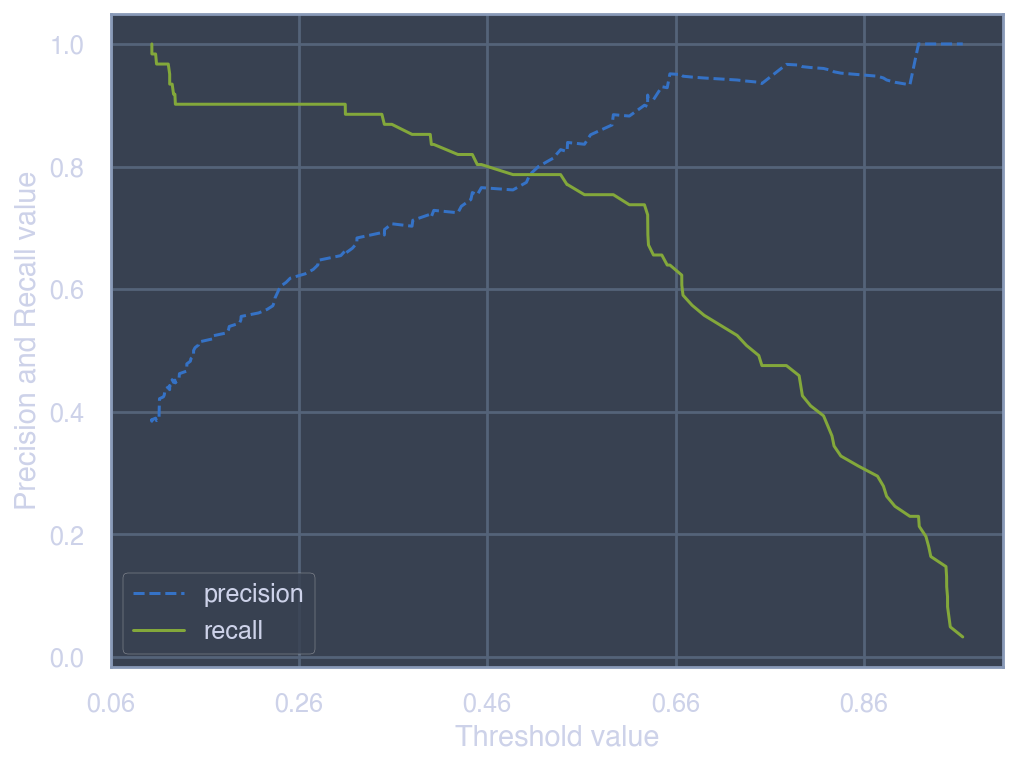

In [35]:
# 이제 그래프로 그려보자
from jupyterthemes import jtplot
jtplot.style(theme="oceans16", context="notebook", ticks=True, grid=False)
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출.
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 plot수행. 정밀도는 점선표시!
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle="--", label="precision")
    plt.plot(thresholds, recalls[0:threshold_boundary], label="recall")
    
    #threshold 값 X축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.2), 2))
    
    # x축, y축 label과 legend, grid설정
    plt.xlabel("Threshold value"); plt.ylabel("Precision and Recall value")
    plt.legend(); plt.grid()
    plt.show()
    
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1])


In [ ]:
# F1스코어는 정밀도(precison) + 재현율(recall)을 결합한 지표입니다. 어느 한쪽으로 치우칠때, 상대적으로 높은 스코어를 가짐

$$F1 =\frac{2}{\frac{1}{recall} + \frac{1}{precision}} = 2 *\frac{precision * recall}{precision+recall}$$

In [36]:
# scikit_learn은 F1스코어를 구하기 위한 f1_score() API를 제공.

from sklearn.metrics import f1_score
f1 = f1_score(y_test, pred)
print("F1 스코어: {0:.4f}".format(f1))

F1 스코어: 0.7805


In [37]:
# threshold별 f1까지 포함된거 구해보자
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    #F1 스코어 추가
    f1 = f1_score(y_test, pred)
    print("오차 행렬")
    print(confusion)
    # f1 score print추가
    print("정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}".\
          format(accuracy, precision, recall, f1))

thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)
    
    
    


임게값: 0.4
오차 행렬
[[98 20]
 [10 51]]
정확도: 0.8324, 정밀도: 0.7183, 재현율: 0.8361, F1:0.7727
임게값: 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.7656, 재현율: 0.8033, F1:0.7840
임게값: 0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869, F1:0.7805
임게값: 0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8364, 재현율: 0.7541, F1:0.7931
임게값: 0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8824, 재현율: 0.7377, F1:0.8036


In [ ]:
# ROC, AUC Curve!

#ROC 는 FPR(False Positive Rate)가 변할때, TPR(True Positive Rate)이 어떻게 변하는지는 나타내는 곡선
# TPR = 재현율을 나타냄(민감도)
# TNR = Negative가 정확히 예측돼야 하는 수준을 나타냄. TN / (FP + TN)

In [39]:
# TPR(민감도) = TP / (TP+FN)
# TNR(특이성) = TN / (TN+FP)
# 즉 FPR = FP / (FP+TN) = 1 - TNR = 1 - 특이성

# 사이킷런은 ROC곡선을 구하기 위해 roc_curve() API를 제공

from sklearn.metrics import roc_curve

# 레이블 값이 1일 때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)
# 반환된 임계값 배열 로우가 47건, 샘플로 10건, 임계값 5steps
thr_index = np.arange(0, thresholds.shape[0], 5)
print("샘플 추출을 위한 임곗값 배열의 index 10개:", thr_index)
print("샘플용 10개의 임곗값:", np.round(thresholds[thr_index], 2))

# 5step 단위로 추출된 임계값에 따른 FPR, TPR값
print("샘플 임곗값별 FPR", np.round(fprs[thr_index], 3))
print("샘플 임곗값별 TPR", np.round(tprs[thr_index], 3))

샘플 추출을 위한 임곗값 배열의 index 10개: [ 0  5 10 15 20 25 30 35 40 45 50]
샘플용 10개의 임곗값: [1.97 0.75 0.63 0.59 0.49 0.4  0.35 0.23 0.13 0.12 0.11]
샘플 임곗값별 FPR [0.    0.017 0.034 0.051 0.127 0.161 0.203 0.331 0.585 0.636 0.797]
샘플 임곗값별 TPR [0.    0.475 0.689 0.754 0.787 0.836 0.869 0.902 0.918 0.967 0.967]


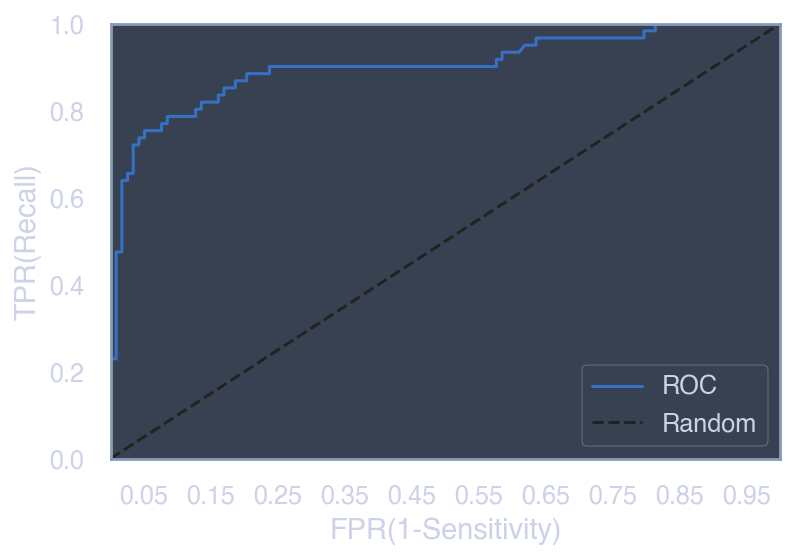

In [40]:
# ROC 커프의 결과를 보면, 임계값이 1에 가까운 값에서 점점 작아지면서 FPR이 점점 커짐. FPR이 조금씩 커질 때 TPR은 가파르게
# 커짐. 시각화해보자

def roc_curve_plot(y_test, pred_proba_c1):
    # 임곗값에 따른 FPR, TPR값을 반환받음
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    #ROC 곡선을 그래프 곡선으로 그림
    plt.plot(fprs, tprs, label="ROC")
    #가운데 대각ㄱ선 직선을 그림.
    plt.plot([0,1],[0,1], "k--", label="Random")
    
    # FPR X축의 Scale을 0.1 단위로 변경, X,Y축명 설정
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.xlim(0, 1); plt.ylim(0, 1)
    plt.xlabel("FPR(1-Sensitivity)"); plt.ylabel("TPR(Recall)")
    plt.legend()
roc_curve_plot(y_test, pred_proba[:, 1])

In [ ]:
# AUC (Area Under Curve)값은 ROC곡선 밑의 면적을 구한것으로써, 일반적으로 1에 가까울 수록 좋은 수치. 
# AUC수치가 커지려면, FPR이 작은 상태에서 얼마나 TPR을 얻을 수 가 있는지가 관건이다.
# 가운데 직선에서 멀어지고, 왼쪽 상단 모서리쪽으로 가파르게 곡선이 이동할수록 직사각형에 가까운 곡선이 된다.

In [41]:
# ROC, AUC를 구하기 위해 roc_auc_score() API를 제공

from sklearn.metrics import roc_auc_score

pred = lr_clf.predict(X_test)
roc_score = roc_auc_score(y_test, pred)
print("ROC AUC값: {0:.4f}".format(roc_score))

ROC AUC값: 0.8341
